In [1]:
#Load packages and libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix

from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds

In [2]:
#Data Loading and Preprocessing
train_data = pd.read_csv('marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv', sep='\t')
print(train_data.columns)

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')


In [3]:
train_data.head()

,Uniq Id,Crawl Timestamp,Dataset Origin,Product Id,Product Barcode,Product Company Type Source,Product Brand Source,Product Brand Normalised Source,Product Name Source,Match Rank,...,Product Currency,Product Available Inventory,Product Image Url,Product Model Number,Product Tags,Product Contents,Product Rating,Product Reviews Count,Bsr,Joining Key
0,1705736792d82aa2f2d3caf1c07c53f4,2020-09-24 03:21:12 +0000,NaN,2e17bf4acecdece67fc00f07ad62c910,NaN,Competitor,NaN,NaN,NaN,NaN,...,USD,111111111,https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",NaN,NaN,NaN,NaN,81350af1be98d3753cf964709f0c766a
1,95a9fe6f4810fcfc7ff244fd06784f11,2020-10-30 14:04:08 +0000,NaN,076e5854a62dd283c253d6bae415af1f,NaN,Competitor,NaN,NaN,NaN,NaN,...,USD,111111111,https://i5.walmartimages.com/asr/9c8e42e4-13a5...,NaN,"Nice 'n Easy Permanent Color, 111 Natural Medi...",NaN,NaN,NaN,NaN,0353e63907dc0de0c734db4690300057
2,8d4d0330178d3ed181b15a4102b287f2,2020-08-06 05:51:47 +0000,NaN,8a4fe5d9c7a6ed26cc44d785a454b124,NaN,Competitor,NaN,NaN,NaN,NaN,...,USD,111111111,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,NaN,Clairol Nice 'N Easy Permanent Color 7/106A Na...,NaN,4.5,29221.0,NaN,b6985c8e94815fbca2319dbb8bf228af
3,fddc4df45b35efd886794b261f730c51,2020-07-15 11:22:04 +0000,NaN,03b5fb878a33eadff8b033419eab9669,NaN,Competitor,NaN,NaN,NaN,NaN,...,USD,111111111,https://i5.walmartimages.com/asr/25b4b467-bc61...,NaN,"Kokie Professional Matte Lipstick, Hot Berry, ...",NaN,NaN,NaN,NaN,85b70fded09186f00467cea2f935b779
4,0990cf89a59ca6a0460349a3e4f51d42,2020-11-26T12:27:20+00:00,NaN,ce3d761e57d6ccad80619297b5b1bcbc,NaN,Competitor,NaN,NaN,NaN,NaN,...,USD,111111111,https://i5.walmartimages.com/asr/1a2ebb06-cd01...,NaN,"Gillette TRAC II Plus Razor Blade Refills, Fit...",NaN,NaN,131.0,NaN,41c870871328e97da6fb036bb7d4b2da


In [4]:
train_data['Product Tags']

,Product Tags
0,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,"Gillette TRAC II Plus Razor Blade Refills, Fit..."
...,...
4995,"Garden Mint Room Spray (Double Strength), 4 ou..."
4996,Garnier Nutrisse Nourishing Hair Color Creme (...
4997,"Nail File Electric Drill, 6 in 1 Professional ..."
4998,Creed Love In Black Hair And Body Wash 6.8oz/2...


In [5]:
train_data.shape

(5000, 32)

In [6]:
train_data.isnull().sum().sort_values(ascending = False)

,0
Match Type,5000
Product Contents,5000
Dataset Origin,5000
Bsr,5000
Product Barcode,5000
Match Rank,5000
Match Score,5000
Product Model Number,5000
Upc,5000
Sku,5000


In [7]:
# extract important columns
train_data = train_data[['Uniq Id','Product Id','Product Rating','Product Reviews Count','Product Category','Product Brand','Product Name','Product Image Url','Product Description','Product Tags']]
train_data.columns

Index(['Uniq Id', 'Product Id', 'Product Rating', 'Product Reviews Count',
       'Product Category', 'Product Brand', 'Product Name',
       'Product Image Url', 'Product Description', 'Product Tags'],
      dtype='object')

In [8]:
train_data.shape

(5000, 10)

In [9]:
train_data.isnull().sum().sort_values(ascending = False)

,0
Product Rating,2806
Product Reviews Count,1654
Product Description,1127
Product Brand,13
Product Category,10
Uniq Id,0
Product Id,0
Product Name,0
Product Image Url,0
Product Tags,0


In [10]:
#fill missing values
train_data.fillna({'Product Rating': 0, 'Product Reviews Count': 0, 'Product Category':'','Product Brand':'','Product Description':''}, inplace=True)
 #any missing (or NaN) values in the 'Product Rating' column are replaced by 0, and it updates the DataFrame directly.
 #inplace=True: This updates the DataFrame directly without creating a copy.
 #Why This Avoids Chained Assignment:
# In this example, there’s no intermediate slicing (e.g., df['Product Rating']) that creates a copy.
# The operation is done directly on the entire DataFrame, updating multiple columns at once,
# so there is no risk of accidentally modifying a view rather than the original DataFrame.

<ipython-input-10-9c379aeb14f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.fillna({'Product Rating': 0, 'Product Reviews Count': 0, 'Product Category':'','Product Brand':'','Product Description':''}, inplace=True)


In [11]:
train_data.isnull().sum()

,0
Uniq Id,0
Product Id,0
Product Rating,0
Product Reviews Count,0
Product Category,0
Product Brand,0
Product Name,0
Product Image Url,0
Product Description,0
Product Tags,0


In [12]:
#check duplicate values
train_data.duplicated().sum()

0

In [13]:
#make column names shorter
#define the mapping of current column names to shorter names
column_name_mapping = {
    'Uniq Id' : 'ID',
    'Product Id' : 'ProdID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name' : 'Name',
    'Product Image Url': 'ImageURL',
    'Product Description': 'Description',
    'Product Tags' : 'Tags',
    'Product Contents': 'Contents'
}

# Rename the columns using the mapping
train_data.rename(columns = column_name_mapping, inplace=True)
print(train_data.columns)


Index(['ID', 'ProdID', 'Rating', 'ReviewCount', 'Category', 'Brand', 'Name',
       'ImageURL', 'Description', 'Tags'],
      dtype='object')


<ipython-input-13-e7dabf699d65>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.rename(columns = column_name_mapping, inplace=True)


In [14]:
train_data['ID'] = train_data['ID'].str.extract(r'(\d+)').astype(float)
# train_data['ID'].str.extract(r'(\d+)') : This extracts only the numeric part (digits) from the 'ID' column, which likely contains strings.
#The regular expression r'(\d+)' is used to find one or more digits (\d+) and captures them in a group.
#This method returns a DataFrame with the extracted numeric values.
#.astype(float) : After extracting the numeric values (which will initially be in string format), this converts them into floating-point numbers (float type).

<ipython-input-14-db9f854bc419>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['ID'] = train_data['ID'].str.extract(r'(\d+)').astype(float)


In [15]:
train_data['ProdID'] = train_data['ProdID'].str.extract(r'(\d+)').astype(float)

In [16]:
train_data.head()

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1.705737e+09,2.0,0.0,0.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,9.500000e+01,76.0,0.0,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8.000000e+00,8.0,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,4.000000e+00,3.0,0.0,0.0,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,9.900000e+02,3.0,0.0,131.0,Seasonal > Stock Up Essentials > Personal Care...,Gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"In 1971, Gillette introduced the Trac II razor...","Gillette TRAC II Plus Razor Blade Refills, Fit..."


In [17]:
# EDA
#number of unique users and items
num_users = train_data['ID'].nunique()
num_items = train_data['ProdID'].nunique()
num_ratings = train_data['Rating'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of unique ratings: {num_ratings}")

Number of unique users: 1721
Number of unique items: 1697
Number of unique ratings: 36


In [18]:
# summary statistics of 'rating' variable
train_data['Rating'].describe()

,Rating
count,5000.000000
mean,1.884480
std,2.192057
min,0.000000
25%,0.000000
50%,0.000000
75%,4.400000
max,5.000000


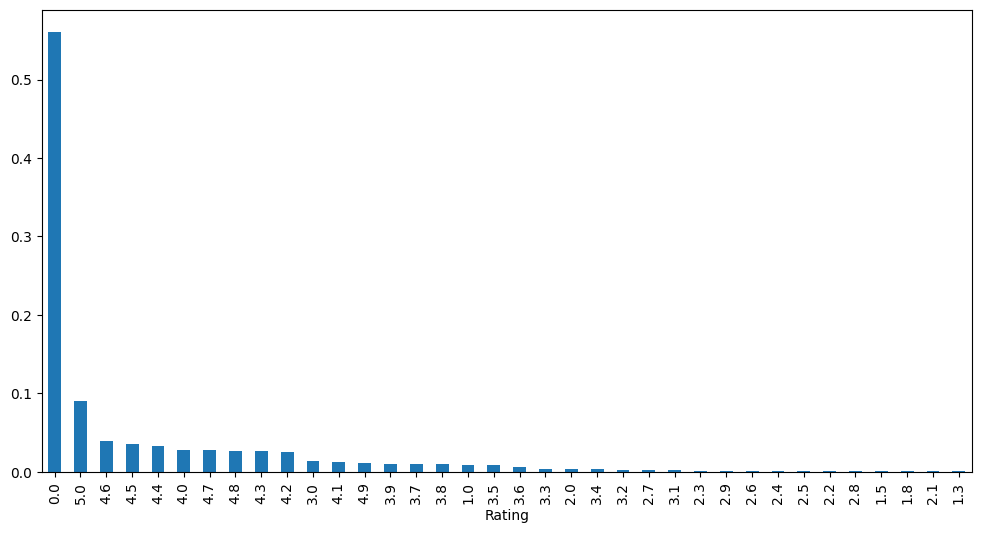

In [19]:
#Rating distribution
plt.figure(figsize = (12,6))
train_data['Rating'].value_counts(1).plot(kind='bar')
plt.show()

In [20]:
#Users with most no of rating
#top 10 users based on rating
most_rated = train_data.groupby('ID').size().sort_values(ascending=False)[:10]
most_rated

<ipython-input-20-3ac291ba23e7>:3: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  most_rated = train_data.groupby('ID').size().sort_values(ascending=False)[:10]


,0
ID,
7.0,224
2.0,218
6.0,214
8.0,206
0.0,204
...,...
61.0,11
56.0,10
38.0,10


 by filtering the dataset to include only users who have rated 50 or more products, you aim to reduce sparsity, improve model performance, mitigate bias, and focus on active and engaged users. This approach enhances the overall quality of your dataset, making it easier to work with and potentially leading to better outcomes in recommendation systems or analyses.








In [21]:
#Let's take a subset of the dataset (by only keeping the users who have given 5 or more ratings) to make the dataset less sparse and easy to work with.
counts = train_data['ID'].value_counts()
train_data_final = train_data[train_data['ID'].isin(counts[counts >= 5].index)]

print('The number of observations in the final data =', len(train_data_final))
print('Number of unique USERS in the final data = ', train_data_final['ID'].nunique())
print('Number of unique PRODUCTS in the final data = ', train_data_final['ProdID'].nunique())

The number of observations in the final data = 3175
Number of unique USERS in the final data =  101
Number of unique PRODUCTS in the final data =  1160


1.The dataframe train_data_final has users who have rated 5 or more items

2.We will use train_data_final to build recommendation systems





#Checking the density of the rating matrix

In [22]:
# Average the duplicate ratings for each user-product combination
train_data_final = train_data_final.groupby(['ID', 'ProdID']).agg({'Rating': 'mean'}).reset_index()
#The result is a new DataFrame where each user-product pair has a single rating that reflects the average of all ratings given by that user for that product.

#creating the interaction matrix of products and users based on ratings and replacing Nan
final_ratings_matrix = train_data_final.pivot(index = 'ID', columns = 'ProdID', values = 'Rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)
#This code creates a user-product interaction matrix where each cell represents the rating a user gave to a product. If a user hasn’t rated a product, that cell is filled with 0

#finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
#Multiplying the number of users (rows) by the number of products (columns) gives the total possible number of user-product rating combinations.
#It represents how many ratings could exist if every user rated every product.

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()



Shape of final_ratings_matrix:  (101, 1160)
given_num_of_ratings =  1112
possible_num_of_ratings =  117160
density: 0.95%


ProdID,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00,9.000000e+00,...,1.001111e+42,1.007940e+42,1.008730e+42,1.030521e+42,1.030521e+42,1.030521e+42,1.076430e+42,3.002240e+42,5.002240e+42,5.005509e+42
ID,,,,,,,,,,,,,,,,,,,,,
0.0,2.840000,1.376923,2.057143,1.587500,1.775000,0.000000,2.112500,1.975000,1.000000,1.011111,...,0.0,0.000000,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
1.0,1.720000,0.000000,2.122222,2.753846,0.700000,2.333333,3.325000,2.350000,0.000000,2.422222,...,0.0,4.700000,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
2.0,1.285714,1.880000,3.062500,1.890909,2.663636,1.400000,0.766667,2.233333,1.336364,1.900000,...,0.0,3.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.6
3.0,1.740000,1.125000,1.583333,2.675000,0.785714,3.314286,1.433333,0.000000,0.000000,3.540000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,3.525000,0.650000,2.462500,1.960000,1.550000,1.942857,0.415385,2.714286,1.866667,3.820000,...,0.0,1.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculating the density gives you insight into how complete your user-product rating data is. It helps in understanding the level of sparsity in the dataset, evaluating the data quality, and guiding the choice of recommendation algorithms.

#Evaluating the Quality of Data
A higher density means that the dataset is richer with user-product interactions, making it easier for models to find patterns and make accurate recommendations.

A lower density suggests that the dataset is more sparse, meaning most users have rated only a few products. This can make it harder for algorithms to generalize user preferences, especially for those with few ratings.

#Choosing the Right Algorithm

Knowing the density helps in selecting the right recommendation approach:

If the dataset is dense, collaborative filtering techniques like matrix factorization might work well.

If the dataset is sparse, other techniques such as content-based filtering or hybrid models might be more suitable.

#Model based Collaborative Filtering : Singular Value Decomposition

We have seen above that the interaction matrix is highly sparse. SVD is best to apply on a large sparse matrix. Note that for sparse matrices, we can use the sparse.linalg.svds() function to perform the decomposition

Also, we will use k=50 latent features to predict rating of products

SVD is used in highly sparse systems to find patterns and relationships between users and products, allowing for better recommendations.

And also:

Dimensionality Reduction: SVD helps in reducing the large, sparse matrix into smaller, dense matrices that capture the essential relationships between users and products. This makes it easier to work with the data despite its sparsity.

Latent Features Extraction: Even though most user-product interactions are missing, SVD can identify latent features—underlying factors that explain user preferences. For example, it might uncover hidden patterns like users who rate certain types of products similarly.

#CSR matrix

A csr_matrix (Compressed Sparse Row matrix) is an efficient way to store large, sparse matrices (matrices with many zero values) because it only stores the non-zero elements and their positions

In [23]:
from scipy.sparse import csr_matrix
final_ratings_sparse = csr_matrix(final_ratings_matrix.values) #This code converts the dense (normal) final_ratings_matrix into a sparse matrix (final_ratings_sparse), which is more memory-efficient and faster to process if most of the elements are zeros
#because it only stores the non-zero elements and their positions.

#SVD

This code converts a user-product ratings matrix into a more memory-efficient sparse format, then uses SVD to decompose it into matrices that capture user and product relationships through 50 latent features. This decomposition is useful for dimensionality reduction and helps in building recommendation systems by identifying hidden patterns in user preferences and product characteristics.

In [24]:
#Singular Value Decomposition
U, s, Vt = svds(final_ratings_sparse, k = 50) # here k is the number of latent features

# Construct diagonal array in SVD
sigma = np.diag(s)


In [25]:
U.shape

(101, 50)

In [26]:
sigma.shape

(50, 50)

In [27]:
Vt.shape

(50, 1160)

regenerate the original matrix using U, Sigma, and Vt matrices. The resulting matrix would be the predicted ratings for all users and products

#Predicting ratings

In [28]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

#predicted ratings
preds_train_data = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
preds_train_data.head()
preds_matrix = csr_matrix(preds_train_data.values)
#This code reconstructs the user-product ratings matrix using the results from SVD to generate predicted ratings for all user-product pairs.

#Function to recommend products

#recommend_items, generates a list of recommended products for a specific user based on their predicted ratings.


#Input Parameters:
user_index: The index of the user for whom we want to generate recommendations.

interactions_matrix: The matrix containing actual ratings given by users to products.

preds_matrix: The matrix containing predicted ratings for each user-product pair.

num_recommendations: The number of product recommendations to return.
Extracting User Ratings:

#user_ratings:
 Gets the actual ratings the user has given to products, converted to a 1D array.

#user_predictions:
Gets the predicted ratings for the user from the prediction matrix, also converted to a 1D array.

#Creating a DataFrame:
Combines the actual ratings and predicted ratings into a DataFrame called temp, where each row represents a product.

#Filtering for Unrated Products:
Keeps only the rows where actual ratings are 0, meaning the user hasn't interacted with those products yet. These are the potential products to recommend.

#Sorting and Recommending:
Sorts the remaining products by predicted ratings in descending order so that products with the highest predicted ratings appear first.
Displays the top num_recommendations products for the user.

This function identifies products that a user hasn't interacted with yet, sorts them based on predicted ratings, and recommends the products that the system thinks the user will like the most. It’s useful for suggesting new products that the user may enjoy.

In [29]:
def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):

  #Get the user's ratings from the actual and predicted interation matrices
  user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
  user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

  #Creating a dataframe with actual and predicted ratings columns
  temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
  temp['Recommended Products'] = np.arange(len(user_ratings))
  temp = temp.set_index('Recommended Products')

  #filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
  temp = temp.loc[temp.user_ratings == 0]

  #Recommending products with top predicted ratings
  temp = temp.sort_values('user_predictions', ascending=False)#sort the dataframe by user_predictions in descending order
  print('\nBelow are the recommended products for user(ID = {}):\n'.format(user_index))
  print(temp['user_predictions'].head(num_recommendations))

#Recommending top 5 products to user id 8

In [30]:
#Enter 'user_index' and 'num_recommendations' for the user
recommend_items(8,final_ratings_sparse,preds_matrix,5)




Below are the recommended products for user(ID = 8):

Recommended Products
754     0.080796
135     0.077262
1076    0.054248
562     0.052181
155     0.049508
Name: user_predictions, dtype: float64


#Recommending top 10 products to user id 57

In [31]:
recommend_items(57, final_ratings_sparse, preds_matrix, 10)


Below are the recommended products for user(ID = 57):

Recommended Products
93      1.063887
717     0.847060
986     0.827808
61      0.778768
971     0.722130
771     0.673618
1158    0.605440
1146    0.591470
580     0.563614
430     0.544250
Name: user_predictions, dtype: float64


#Evaluating the model

In [32]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

#Actual ratings given by users
final_ratings_matrix.head()
#This code adds a new index (user_index) to the final_ratings_matrix, where each user gets a unique numeric ID starting from 0.
#This makes it easier to reference users by their index when working with the matrix, such as during recommendation or evaluation tasks.








ProdID,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00,9.000000e+00,...,1.001111e+42,1.007940e+42,1.008730e+42,1.030521e+42,1.030521e+42,1.030521e+42,1.076430e+42,3.002240e+42,5.002240e+42,5.005509e+42
user_index,,,,,,,,,,,,,,,,,,,,,
0,2.840000,1.376923,2.057143,1.587500,1.775000,0.000000,2.112500,1.975000,1.000000,1.011111,...,0.0,0.000000,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
1,1.720000,0.000000,2.122222,2.753846,0.700000,2.333333,3.325000,2.350000,0.000000,2.422222,...,0.0,4.700000,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
2,1.285714,1.880000,3.062500,1.890909,2.663636,1.400000,0.766667,2.233333,1.336364,1.900000,...,0.0,3.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.6
3,1.740000,1.125000,1.583333,2.675000,0.785714,3.314286,1.433333,0.000000,0.000000,3.540000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.525000,0.650000,2.462500,1.960000,1.550000,1.942857,0.415385,2.714286,1.866667,3.820000,...,0.0,1.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
average_rating = final_ratings_matrix.mean()
average_rating.head()

,0
ProdID,
0.0,1.186597
1.0,0.761367
2.0,0.984127
3.0,1.106378
4.0,0.542114


In [34]:
preds_train_data.head()

ProdID,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00,9.000000e+00,...,1.001111e+42,1.007940e+42,1.008730e+42,1.030521e+42,1.030521e+42,1.030521e+42,1.076430e+42,3.002240e+42,5.002240e+42,5.005509e+42
0,2.835963,1.374368,2.054460,1.585592,1.778583,0.007263,2.099993,1.982633,0.997121,1.019126,...,0.002493,0.005975,0.0,0.002606,0.000055,0.002216,4.992694,0.0,0.005602,0.005937
1,1.712302,0.010973,2.110722,2.763784,0.709723,2.340684,3.325994,2.359863,0.022403,2.425173,...,0.000621,4.703619,0.0,0.000649,5.059165,0.004099,0.001000,0.0,0.019613,0.002597
2,1.292759,1.895257,3.063743,1.886585,2.655244,1.407691,0.773696,2.218008,1.345059,1.898543,...,0.001013,3.134308,0.0,0.001059,0.003646,0.000147,0.006454,0.0,0.019200,4.583268
3,1.736789,1.127175,1.589938,2.675641,0.772583,3.321915,1.423310,0.012164,0.009580,3.536519,...,0.001879,0.004839,0.0,0.001964,0.023191,0.001617,0.003189,0.0,0.071695,0.001384
4,3.549921,0.656676,2.457060,1.957798,1.543499,1.923719,0.410546,2.700657,1.900877,3.836725,...,0.000699,1.362779,0.0,0.000731,0.003256,0.006613,0.001089,0.0,0.035853,0.001967


In [35]:
avg_preds = preds_train_data.mean()
avg_preds.head()

,0
ProdID,
0.0,1.228485
1.0,0.808201
2.0,1.025858
3.0,1.150011
4.0,0.602024


In [36]:
rmse_train_data = pd.concat([average_rating, avg_preds], axis=1)

rmse_train_data.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_train_data.head()

,Avg_actual_ratings,Avg_predicted_ratings
ProdID,,
0.0,1.186597,1.228485
1.0,0.761367,0.808201
2.0,0.984127,1.025858
3.0,1.106378,1.150011
4.0,0.542114,0.602024


In [37]:
RMSE = mean_squared_error(rmse_train_data['Avg_actual_ratings'], rmse_train_data['Avg_predicted_ratings'], squared = False)
print(f'RMSE SVD Model = {RMSE} \n')

RMSE SVD Model = 0.03835989624869733 



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
